In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import time

In [2]:
"""import kagglehub

# Download latest version
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

print("Path to dataset files:", path)"""

'import kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")\n\nprint("Path to dataset files:", path)'

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    r'C:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\transfer_learning_reference_2\treino',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed = 123)

validation_ds = keras.utils.image_dataset_from_directory(
    r'C:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\transfer_learning_reference_2\treino',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed = 123)

# Passar 60 baches de treino para teste
test_ds = train_ds.take(60)
train_ds = train_ds.skip(60)


Found 6499 files belonging to 75 classes.
Using 5850 files for training.
Found 6499 files belonging to 75 classes.
Using 649 files for validation.


In [4]:
# Em bachts de 32
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f'Number of testing samples: {test_ds.cardinality()}')

Number of training samples: 123
Number of validation samples: 21
Number of testing samples: 60


In [5]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))


In [6]:
# Tirando das batchs para fazer data augmentation
train_ds = train_ds.unbatch()

augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

def augment_image(image, label):
    """
    Applies data augmentation and creates multiple versions of an image.
    """

    image_versions = [image] # Essa lista vai conter todas as diferentes versões da imagem, começando com a original

    for _ in range(4): # Cada imagem vai virar 5 (contando com ela mesma)
        augmented_image = image
        for layer in augmentation_layers:
            # Tem que ter o training = True para garantir que ele vai aplicar as camadas de augmentation
            augmented_image = layer(augmented_image, training=True)
        image_versions.append(augmented_image) # Guarda as imagens modificadas na mesma lista

    images_tensor = tf.stack(image_versions) # Transforma a lista em um tensor
    

    labels_tensor = tf.repeat(label, repeats = 5) # Repetindo as labels para ficar igual
    
    # Tem que retornar um tensor para o flat_map
    return tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))


train_ds = train_ds.flat_map(augment_image)
train_ds = train_ds.batch(32)


In [7]:
# Em bachts de 32

print(f"Number of training samples: {len(list(train_ds))}") 
# Agora a gente tem 615 batches (5 vezes mais que antes), quando usamos o flat_map o keras para de ficar sabendo quantos batches tem diretamente pelo .cardinality()

print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f'Number of testing samples: {test_ds.cardinality()}')

Number of training samples: 615
Number of validation samples: 21
Number of testing samples: 60


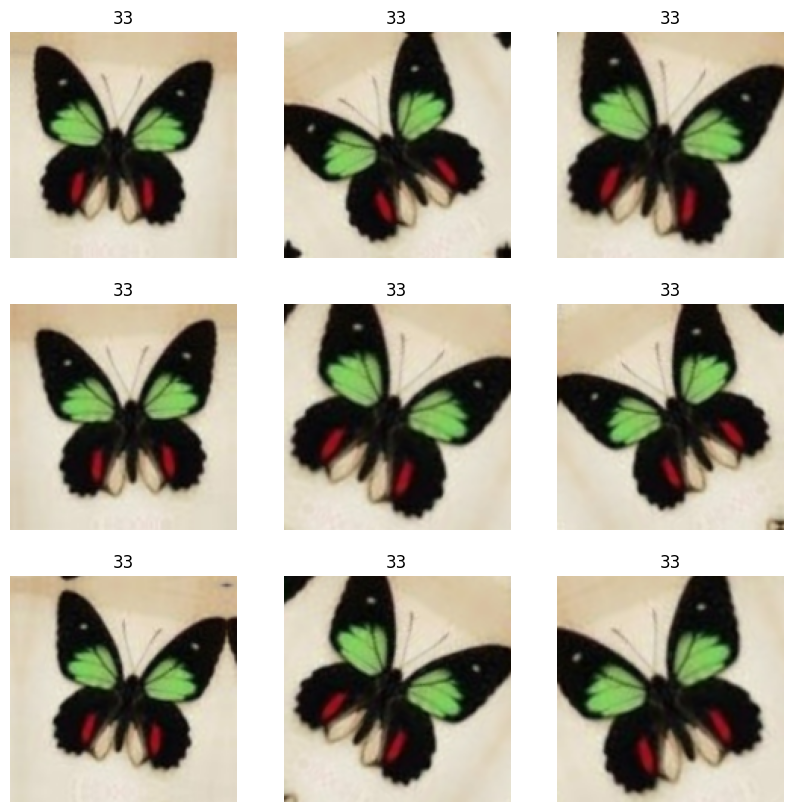

In [8]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [10]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Carregando os pesos do modelo pré-treinado no dataset imaginet.
    input_shape=(150, 150, 3),
    include_top=False,  # Tirar o classificador final do modelo
) # O imaginet 1000 utilizado contém 5 espécies de borboletas (ringlet, monarch, cabbage, sulphur, lycaenid) e só monarch e cabbage aparecem no nosso dataset.

# Congelando o modelo base
base_model.trainable = False

global_pool = keras.layers.GlobalAveragePooling2D()

def extract_features(images, labels):
    # images: a batch tensor (batch_size, 150, 150, 3)
    # Ensure float dtype and rescale to Xception expected range [-1, 1]
    images = tf.cast(images, tf.float32)
    images = (images / 127.5) - 1.0

    # Get feature maps from the frozen base_model, keep training=False
    feature_maps = base_model(images, training=False)

    # Convert feature maps to 1D feature vectors per sample
    features = global_pool(feature_maps)

    return features, labels

# Map the extraction over datasets
print("Extraindo features do dataset de treino...")
extracted_train_ds = train_ds.map(extract_features, num_parallel_calls=tf.data.AUTOTUNE)

print("Extraindo features do dataset de validação...")
extracted_validation_ds = validation_ds.map(extract_features, num_parallel_calls=tf.data.AUTOTUNE)

print("Extraindo features do dataset de teste...")
extracted_test_ds = test_ds.map(extract_features, num_parallel_calls=tf.data.AUTOTUNE)

print("Extração concluída.")



Extraindo features do dataset de treino...
Extraindo features do dataset de validação...
Extraindo features do dataset de teste...


ValueError: in user code:

    File "C:\Users\pedro.quinet\AppData\Local\Temp\ipykernel_1460\2273131181.py", line 19, in extract_features  *
        feature_maps = base_model(images, training=False)
    File "c:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\.venv\Lib\site-packages\keras\src\layers\input_spec.py", line 245, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "xception" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 256, 256, 3)


In [ ]:
# O input do modelo
inputs = keras.Input(shape=(150, 150, 3))

# O Xception pré treinado requer que os insputs tenham essa escala.
# de (0, 255) para (-1., +1.).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False) # Passar o training = False para deixar o batchnorming layer do base_model em modo inferência.


x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizar com dropout

outputs = keras.layers.Dense(75, activation="softmax")(x) # saída com 75 classes pois temos 75 espécies de borboletas no dataset.

# Criar o modelo final
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model.summary(show_trainable=True)

In [62]:
# Callback para pegar os tempos

class TimingCallback(tf.keras.callbacks.Callback):
    """Callback para registrar o tempo gasto em cada época."""
    
    def __init__(self, logs={}):
        self.times = [] # Lista para armazenar os tempos de cada época

    def on_epoch_begin(self, epoch, logs={}):
        """É chamado no início de uma época."""
        self.starttime = time.time() # Registra o tempo de início

    def on_epoch_end(self, epoch, logs={}):
        """É chamado no final de uma época."""
        # Calcula a duração e adiciona à lista
        duration = time.time() - self.starttime
        self.times.append(duration)

time_callback = TimingCallback()

In [18]:
epochs = 10
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[time_callback])

Fitting the top layer of the model
Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 140s 754ms/step - accuracy: 0.3467 - loss: 2.8367 - val_accuracy: 0.7149 - val_loss: 1.0738
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 144s 785ms/step - accuracy: 0.7416 - loss: 0.9412 - val_accuracy: 0.7643 - val_loss: 0.8296
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 141s 769ms/step - accuracy: 0.7957 - loss: 0.7296 - val_accuracy: 0.7812 - val_loss: 0.7416
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 144s 785ms/step - accuracy: 0.8280 - loss: 0.6107 - val_accuracy: 0.7843 - val_loss: 0.6921
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 142s 774ms/step - accuracy: 0.8439 - loss: 0.5181 - val_accuracy: 0.8120 - val_loss: 0.6214
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 143s 782ms/step - accuracy: 0.8673 - loss: 0.4702 - val_accuracy: 0.7966 - val_loss: 0.6738
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 158s 862ms/step - accuracy: 0.8764 - loss: 0.4324 - val_accuracy: 0.8213 - val_loss: 0.5936
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1

In [31]:
# Extrair os dados do objeto history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_times = time_callback.times
epochs_range = range(1, len(acc) + 1) # Só para não começar do 0

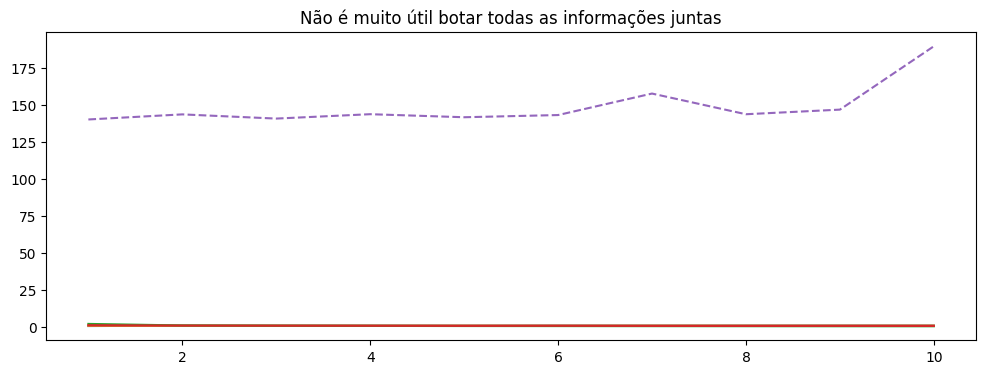

In [32]:
# Não vale a pena plotar tudo junto

plt.figure(figsize=(12, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot(epochs_range, epoch_times, label='Epoch Time', linestyle='--')
plt.title('Não é muito útil botar todas as informações juntas')
plt.show()

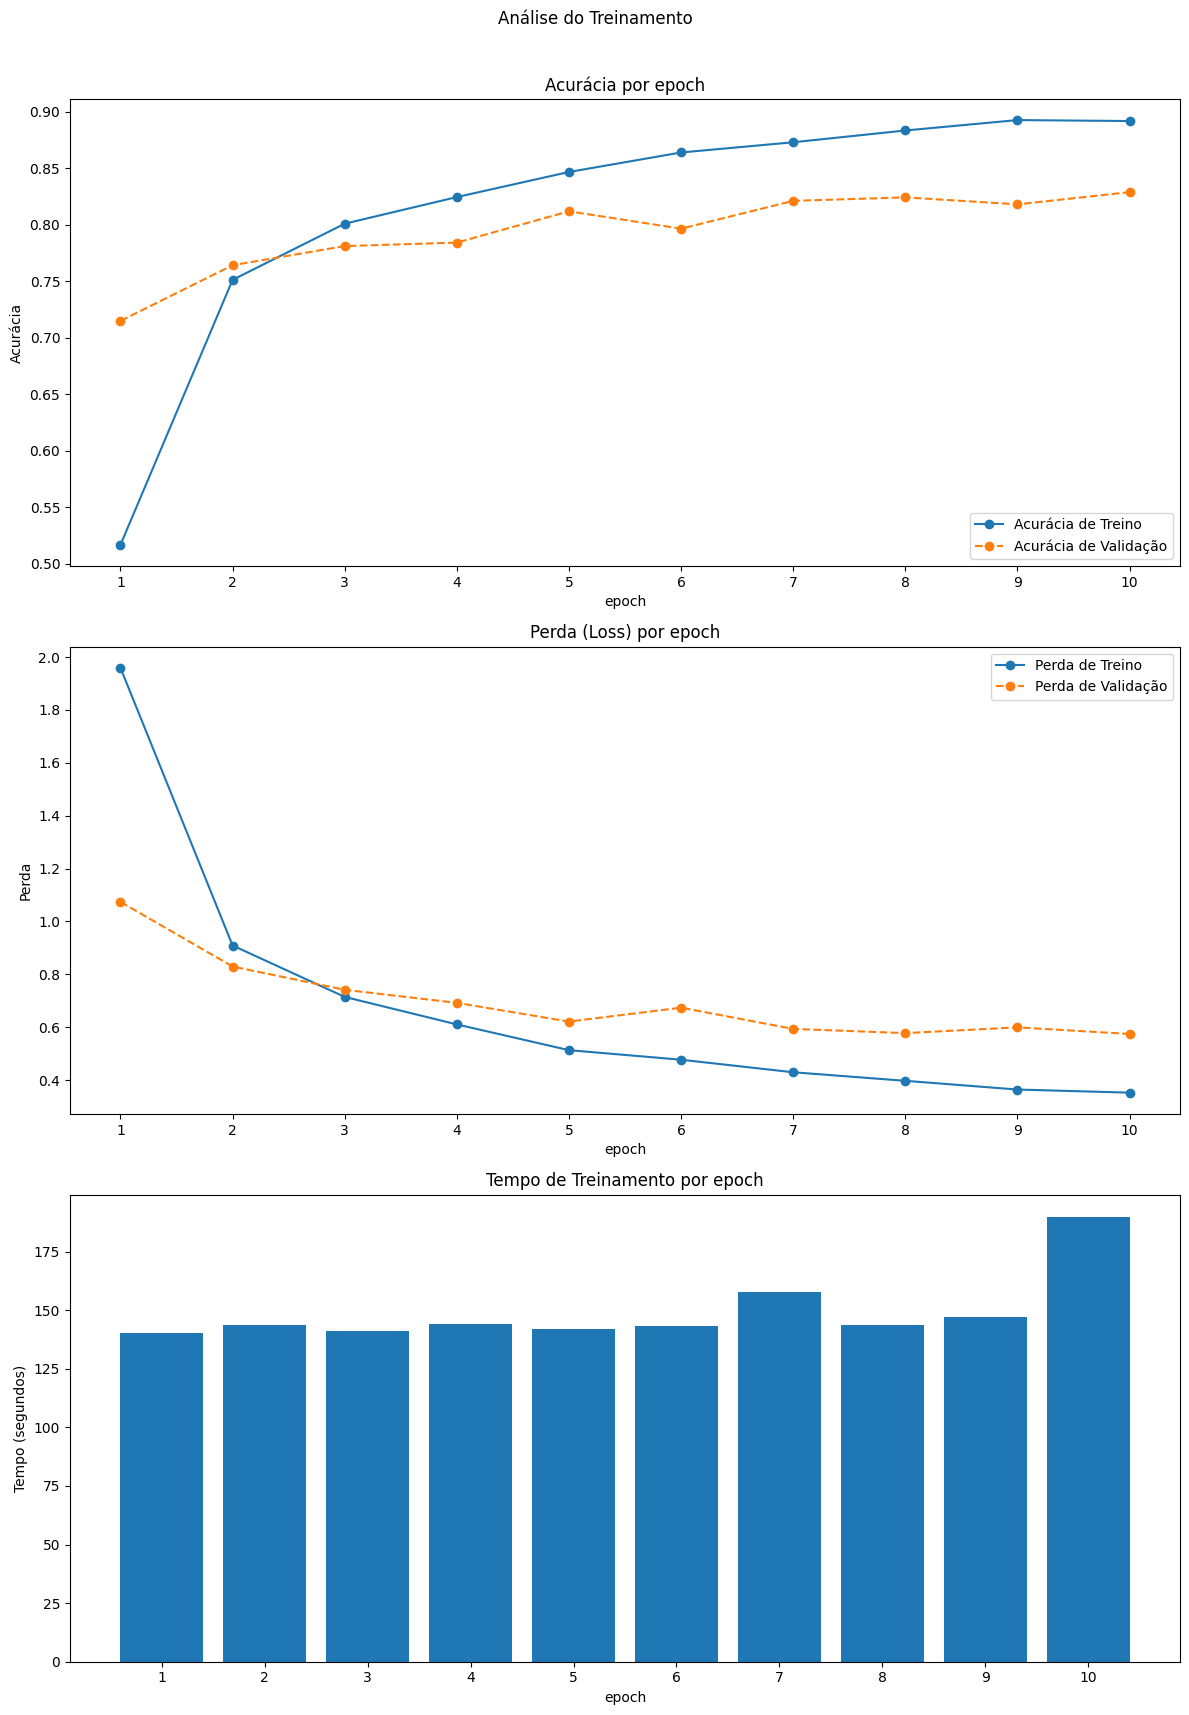

In [33]:

# Criar a figura e os eixos para os plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise do Treinamento')

# Plot 1: Acurácia de Treino e Validação
ax1.plot(epochs_range, acc, 'o-', label='Acurácia de Treino')
ax1.plot(epochs_range, val_acc, 'o--', label='Acurácia de Validação')
ax1.set_title('Acurácia por epoch')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Acurácia')
ax1.legend(loc='lower right') # Para não atrapalhar o gráfico
ax1.set_xticks(epochs_range)


# Plot 2: Loss de Treino e Validação
ax2.plot(epochs_range, loss, 'o-', label='Perda de Treino')
ax2.plot(epochs_range, val_loss, 'o--', label='Perda de Validação')
ax2.set_title('Perda (Loss) por epoch')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Perda')
ax2.legend(loc='upper right') # Para não atrapalhar o gráfico
ax2.set_xticks(epochs_range)


# Plot 3: Tempo por Época
ax3.bar(epochs_range, epoch_times)
ax3.set_title('Tempo de Treinamento por epoch')
ax3.set_xlabel('epoch')
ax3.set_ylabel('Tempo (segundos)')
ax3.set_xticks(epochs_range)

# Ajustar o layout e exibir os plots
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [34]:
# Treinar o modelo completo 

time_callback = TimingCallback() # Poder pegar os tempos de treinamento
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

epochs = 5
print("Fitting the end-to-end model")
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[time_callback])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_7 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_3 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_3  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 75)            │    153,675 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,322,507 (81.34 MB)

 Trainable params: 20,960,627 (79.96 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 307,352 (1.17 MB)

Fitting the end-to-end model
Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 583s 3s/step - accuracy: 0.5314 - loss: 2.0924 - val_accuracy: 0.8151 - val_loss: 0.7300
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - accuracy: 0.7725 - loss: 1.0243 - val_accuracy: 0.8197 - val_loss: 0.6901
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.8484 - loss: 0.6785 - val_accuracy: 0.8552 - val_loss: 0.6021
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 539s 3s/step - accuracy: 0.8830 - loss: 0.5256 - val_accuracy: 0.8706 - val_loss: 0.5259
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 666s 4s/step - accuracy: 0.9000 - loss: 0.4382 - val_accuracy: 0.8767 - val_loss: 0.4763


In [40]:
# Extrair os dados do objeto history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_times = time_callback.times
epochs_range = range(1, len(acc) + 1) # Só para não começar do 0

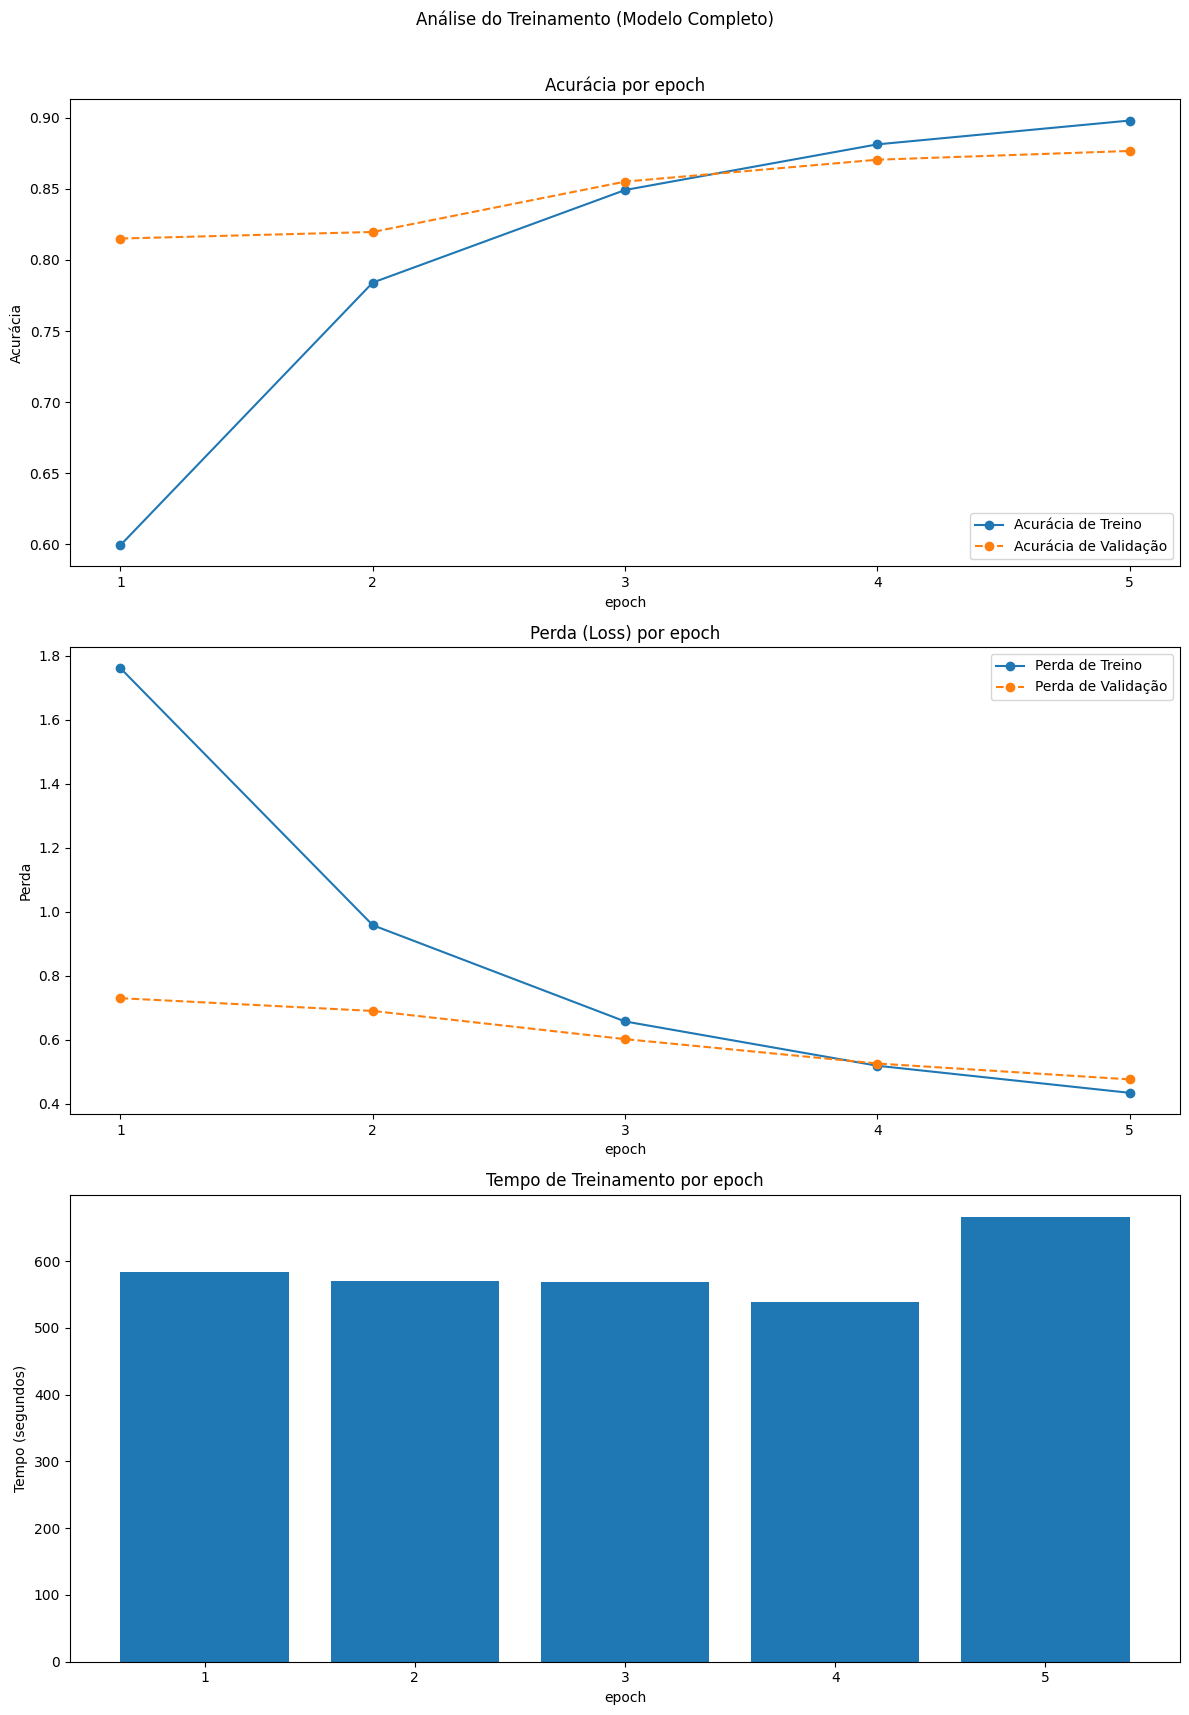

In [41]:
# Criar a figura e os eixos para os plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise do Treinamento (Modelo Completo)')

# Plot 1: Acurácia de Treino e Validação
ax1.plot(epochs_range, acc, 'o-', label='Acurácia de Treino')
ax1.plot(epochs_range, val_acc, 'o--', label='Acurácia de Validação')
ax1.set_title('Acurácia por epoch')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Acurácia')
ax1.legend(loc='lower right') # Para não atrapalhar o gráfico
ax1.set_xticks(epochs_range)


# Plot 2: Loss de Treino e Validação
ax2.plot(epochs_range, loss, 'o-', label='Perda de Treino')
ax2.plot(epochs_range, val_loss, 'o--', label='Perda de Validação')
ax2.set_title('Perda (Loss) por epoch')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Perda')
ax2.legend(loc='upper right') # Para não atrapalhar o gráfico
ax2.set_xticks(epochs_range)


# Plot 3: Tempo por Época
ax3.bar(epochs_range, epoch_times)
ax3.set_title('Tempo de Treinamento por epoch')
ax3.set_xlabel('epoch')
ax3.set_ylabel('Tempo (segundos)')
ax3.set_xticks(epochs_range)

# Ajustar o layout e exibir os plots
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [ ]:
# Os dados de teste não tem labels :-()

print("Validation dataset evaluation")
model.evaluate(validation_ds) # -> Loss, accuracy

Validation dataset evaluation
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 671ms/step - accuracy: 0.8968 - loss: 0.4684


[0.4762765169143677, 0.8767334222793579]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds) # -> Loss, accuracy

In [44]:
# Fica muito pesado salvar o modelo completo e não da pra subir pro github
# model.save(r'C:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\transfer_learning_reference_2\model_weights.keras')